# 04 - Applied ML

## Deadline
Monday November 21, 2016 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution
you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code

## Background
In this homework we will gain experience on Applied Machine Learning, exploring an interesting dataset about soccer players and referees.
You can find all the data in the `CrowdstormingDataJuly1st.csv` file, while you can read a thorough [dataset description here](DATA.md).
Given that the focus of this homework is Machine Learning, I recommend you to first take a look at [this notebook](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb)
containing a solid work in pre-processing + visualization of the given dataset. You are *not* allowed to just copy/paste the pre-processing steps
performed by the notebook authors -- you are still supposed to perform your own data analysis for the homework. Still, I'm confident that consulting first
the work done by expert data analysts will speed up tangibly your effort (i.e., they have already found for you many glitches in the data :)


## Assignment
1. Train a `sklearn.ensemble.RandomForestClassifier` that given a soccer player description outputs his skin color. Show how different parameters 
passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model,
inspect the `feature_importances_` attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even
before feeding them to the classifier), can you obtain a substantially different `feature_importances_` attribute?
*BONUS*: plot the learning curves against at least 2 different sets of parameters passed to your Random Forest. To obtain smooth curves, partition
your data in at least 20 folds. Can you find a set of parameters that leads to high bias, and one which does not?

2. Aggregate the referee information grouping by soccer player, and use an unsupervised learning technique to cluster the soccer players in 2 disjoint
clusters. Remove features iteratively, and at each step perform again the clustering and compute the silhouette score -- can you find a configuration of features with high silhouette
score where players with dark and light skin colors belong to different clusters? Discuss the obtained results.


--------------------------------------------------------------------------------------------------------------
# Data Description

From a company for sports statistics, we obtained data and profile photos from all soccer players (N = 2053) playing in the first male divisions of England, Germany, France and Spain in the 2012-2013 season and all referees (N = 3147) that these players played under in their professional career. We created a dataset of player–referee dyads including the number of matches players and referees encountered each other and our dependent variable, the number of red cards given to a player by a particular referee throughout all matches the two encountered each other.
 
Player photos were available from the source for 1586 out of 2053 players. Players’ skin tone was coded by two independent raters blind to the research question who, based on their profile photo, categorized players on a 5-point scale ranging from “very light skin” to “very dark skin” with “neither dark nor light skin” as the center value. 

Additionally, implicit bias scores for each referee country were calculated using a race implicit association test (IAT), with higher values corresponding to faster white | good, black | bad associations. Explicit bias scores for each referee country were calculated using a racial thermometer task, with higher values corresponding to greater feelings of warmth toward whites versus blacks. Both these measures were created by aggregating data from many online users in referee countries taking these tests on [Project Implicit](http://projectimplicit.net).

In all, the dataset has a total of 146028 dyads of players and referees. A detailed description of all variables in the dataset can be seen in the list below.

## Variables:

*playerShort* - short player ID

*player* - player name

*club* - player club

*leagueCountry* - country of player club (England, Germany, France, and Spain)

*birthday* - player birthday

*height* - player height (in cm)

*weight* - player weight (in kg)

*position* - detailed player position

*games* - number of games in the player-referee dyad

*victories* - victories in the player-referee dyad

*ties* - ties in the player-referee dyad

*defeats* - losses in the player-referee dyad

*goals* - goals scored by a player in the player-referee dyad

*yellowCards* - number of yellow cards player received from referee

*yellowReds* - number of yellow-red cards player received from referee

*redCards* - number of red cards player received from referee

*photoID* - ID of player photo (if available)

*rater1* - skin rating of photo by rater 1 (5-point scale ranging from “very light skin” to “very dark skin”)

*rater2* - skin rating of photo by rater 2 (5-point scale ranging from “very light skin” to “very dark skin”)

*refNum* - unique referee ID number (referee name removed for anonymizing purposes)

*refCountry* - unique referee country ID number (country name removed for anonymizing purposes)

*meanIAT* - mean implicit bias score (using the race IAT) for referee country, higher values correspond to faster white | good, black | bad associations

*nIAT* - sample size for race IAT in that particular country

*seIAT* - standard error for mean estimate of race IAT

*meanExp* - mean explicit bias score (using a racial thermometer task) for referee country, higher values correspond to greater feelings of warmth toward whites versus blacks

*nExp* - sample size for explicit bias in that particular country

*seExp* - standard error for mean estimate of explicit bias measure




--------------------------------------------------------------------------------------------------------------

# IMPLEMENTATION
## Supervised Classification

In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
import preprocessing_helper as preproc_helper
import classifiers_helper as class_helper
import aggregater_helper as aggr_helper
from statistics import mode

In [139]:
data = 'CrowdstormingDataJuly1st.csv'
dyads = pd.read_csv(data)

### 1. Visualization of the data

In [140]:
dyads.ix[:5, :int(len(dyads.columns) / 2)]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0


In [141]:
dyads.ix[:5, 14:len(dyads.columns)]

,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


Through the visualization of the data and the ipython notebook which previously worked on the same dataset, we observed that each data entry is a dyad between a player and a referee. They all contain a player ID, a referee ID, their respective descriptors and some informations about the dyad itself.

We could define a dyad as a relationship between a player and a referee. A dyad can contain multiple encounters of the pair (player <-> referee) from different matches. 



### 2. Cleaning 

First of all, as we have (player <-> referee) dyads, a referee in our dataset should have arbitrated at least one match. This implies that we should find at least 22 dyads containing the given referee (a team has 11 players).
We thus check that for each referee we obtain at least 22 dyads:

In [142]:
referees = pd.DataFrame(dyads.groupby(['refNum']).size())
referees.columns = ['count']
bad_refs = referees[referees['count'] < 22]
nb_refs = len(referees)
nb_badrefs = len(bad_refs)
print("Total number of refs:", nb_refs)
print("Number of refs with missing data:", nb_badrefs)
print("Percentage of refs with missing data:", 100*(nb_badrefs/nb_refs), "%")

Total number of refs: 3147
Number of refs with missing data: 2149
Percentage of refs with missing data: 68.28725770575151 %


We found 2149 referees contained in less than 22 dyads. We can consider these as missing data events. 

In [143]:
dyads_w_rm = dyads.drop(bad_refs.index)
nb_dyads = len(dyads)
nb_dyads_wrm = len(dyads_w_rm)
print("Number of dyads:", nb_dyads)
print("Number of dyads after deletions:", nb_dyads_wrm)
print("Percent of dyads lost:", (100*(1-(nb_dyads_wrm/nb_dyads))),"%")

Number of dyads: 146028
Number of dyads after deletions: 143879
Percent of dyads lost: 1.4716355767387057 %


We see that even that the referees to delete represented 68% of the set of referees, the percentage of lost dyads after a potential removal is only around 1.5%. We thus decide to apply the deletion.

In [144]:
dyads = dyads.drop(bad_refs.index)

### 3. Defining the label

Our goal is to define if a player has dark skin or light skin. We thus need to design a model and train it on a part of this data with predefined skin labels. We will take the columns 'rater1' and 'rater2' to define this label. As the model needs an output (a valid skin label) we need at least one of these columns to be valid.

In [145]:
dyads = dyads[~(np.isnan(dyads['rater1']) & np.isnan(dyads['rater2']))]
dyads.reset_index(inplace=True)

As we have two observations defining the skin's color for each player, we want to aggregate them but first we have to check if there exists disparities between them. We also check what are the different values given by each rater.

In [146]:
print("The max difference between two raters is", (dyads['rater1']-dyads['rater2']).max())
print("Rating values given by rater 1", dyads['rater1'].unique())
print("Rating values given by rater 2", dyads['rater2'].unique())

The max difference between two raters is 0.25
Rating values given by rater 1 [ 0.25  1.    0.5   0.    0.75]
Rating values given by rater 2 [ 0.5   1.    0.25  0.    0.75]


The scale is going from 0 to 1 with a step of 0.25 and the max difference is 0.25.
Therefore we cannot find a case where there are opposite opinions about a player (one black, the other white)

We choose to transform this scale of rating into binary labels. We consider our model to predict more of a white/coloured ouput. We choose to take the mean of these values and if the result is smaller than 0.5 we want to output 0 ('white') and if it is greater than 0.5 output 1 ('black/coloured').

In [147]:
dyads['y'] = (dyads['rater1'] + dyads['rater2']) / 2 
dyads.loc[dyads['y'] < 0.5, 'y'] = 0
dyads.loc[dyads['y'] >= 0.5, 'y'] = 1
dyads.drop(['rater1', 'rater2'], axis=1, inplace=True)

### 4. Training the classifier - Round one
Now that we have clean the data, we can try to create a classifier on it and train it. We first pop the labels, then before label encoding the object columns in the original dataframe, we fill them first with the string 'Unknown' if we encounter a NaN value.

Once the object columns are label encoded, we still fill the NaN values with -999. This is an arbitrary value we choose, since every column should not contain a negative value, it behaves as if it was not known.

In [148]:
dyads_encoded = dyads.copy()
dyads_encoded = preproc_helper.fill_na_columns(dyads_encoded, ['position', 'Alpha_3'], ['Unknown', 'Unknown'])
labels = dyads_encoded.pop('y')
dyads_encoded = preproc_helper.label_encode(dyads_encoded, list(dyads_encoded.select_dtypes(include=['object']).columns))
dyads_encoded.fillna(-999, inplace=True)

In [149]:
classifier = RandomForestClassifier(n_estimators=10)
scores = cross_val_score(classifier, dyads_encoded, labels, cv=10)
print("Cross-val score:", scores.mean())

Cross-val score: 0.996039807148


The classifier score is impressive. Let's look at the important features.

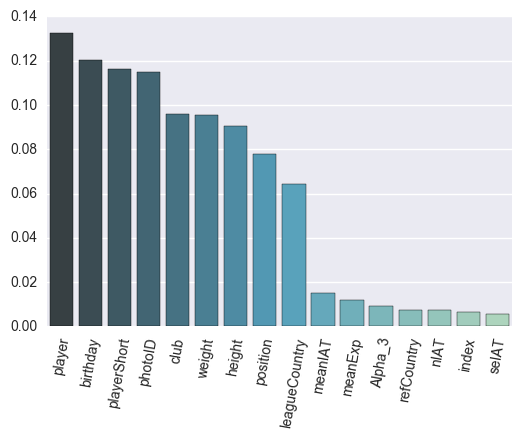

In [150]:
#Feature Importances
class_helper.plot_importances(classifier, dyads_encoded, labels)

Since we train our model with the dyads it means that a same player can be in the train and in the test dataset at the same time, so it's logical that the classifier uses the player name and its unique related informations (birthday, photoID, playerShort) to classify.

As such the model does not make sense.

### 4. Training the classifier - Round two

As seen before the model does not make sense. Hence we move to an approach where we transform our data into a frame with an entry per player. Therefore, this implies, aggregating the dyads players while applying different aggregation functions per columns based on the information it contains. We will thus need to make some choices of interpretation to do the latter.

#### 4.1 Aggregating and cleaning the data

We first aggregate the dyads by players while appending their column informations into arrays. We also need  to not reorder the arrays to keep a mapping between a referee and its informations concerning the player.

In [151]:
players = dyads.groupby(['playerShort'])
players = preproc_helper.groups_to_lists(players, 'playerShort')

As seen in the important features above, some of the columns are unique and represents directly a player. It means that they won't help to classify them. So we decide to drop them.

In [152]:
naive_data = players.drop(['birthday', 'player', 'photoID', 'Alpha_3', 'refCountry','index', 'refNum', 'nIAT', 'nExp'], axis=1)

We have a repetition of values for some columns that are supposed to be constant: 
weight, height, club. We check if the respective lists of those columns per player contain the same value or not.

In [153]:
print(preproc_helper.has_same_value(naive_data['height']))
print(preproc_helper.has_same_value(naive_data['weight']))
print(preproc_helper.has_same_value(naive_data['y']))
print(preproc_helper.has_same_value(naive_data['club']))
print(preproc_helper.has_same_value(naive_data['leagueCountry']))

False
False
True
True
True


As we can see, height and weight can differ for a given player. Is it because the list contains NaN or just different values?

In [154]:
print(preproc_helper.has_nan(naive_data['height']))
print(preproc_helper.has_nan(naive_data['weight']))

True
True


There are NaNs in the height and weight columns for some players. We will replace those by their correct height and weight if we have them in the data.

In [155]:
naive_data['height'] = preproc_helper.replace_nan(naive_data['height'])
naive_data['weight'] = preproc_helper.replace_nan(naive_data['weight'])

print(preproc_helper.has_nan(naive_data['height']))
print(preproc_helper.has_nan(naive_data['weight']))

False
False


There are no more nan values in those columns but are all the values the same?

In [156]:
print(preproc_helper.has_same_value(naive_data['height']))
print(preproc_helper.has_same_value(naive_data['weight']))

False
False


Not yet, let's see if there are players with no height or weight. And drop them.

In [157]:
unique_height = pd.DataFrame(naive_data['height'].apply(lambda row: len(set(row))))
player_nan_height = unique_height[unique_height['height']==0]
unique_weight = pd.DataFrame(naive_data['weight'].apply(lambda row: len(set(row))))
player_nan_weight = unique_weight[unique_weight['weight']==0]

list_diff = set(list(player_nan_weight.index.values) + list(player_nan_height.index.values))
naive_data = naive_data.drop(list_diff)

Now they all have the same value so we will represent it by the first element of each list

#### 4.2 Reducing
We apply different aggregation functions on our columns:
- As discussed, the columns  club, leagueCountry, height and weight are constants. We only take the first element of the array. This is also the case for y since a player do not change skin color over time.
- Since the player's position may change over time, we decide to apply a majority vote on the list of his positions. We also create a "Unknown" position class for the Na cases.
- The columns games, victories, ties, defeats, goals, yellowCards, redCards and yellowReds are simply summed.
- seIAT and seExp becomes the standard deviation of the meanIAT and meanExp a player has.
- We take the average of meanIAT and meanExp

In [158]:
naive_data['y'] = naive_data['y'].apply(lambda x: int(x[0]))
naive_data['club'] = naive_data['club'].apply(lambda x: x[0])
naive_data['leagueCountry'] = naive_data['leagueCountry'].apply(lambda x: x[0])
naive_data['height'] = naive_data['height'].apply(lambda x: x[0])
naive_data['weight'] = naive_data['weight'].apply(lambda x: x[0])
#majority vote
naive_data['position'] = naive_data['position'].apply(mode)
naive_data['position'].fillna("Unknown", inplace=True)
naive_data['games'] = naive_data['games'].apply(lambda x: sum(x))
naive_data['victories'] = naive_data['victories'].apply(lambda x: sum(x))
naive_data['ties'] = naive_data['ties'].apply(lambda x: sum(x))
naive_data['defeats'] = naive_data['defeats'].apply(lambda x: sum(x))
naive_data['goals'] = naive_data['goals'].apply(lambda x: sum(x))
naive_data['yellowCards'] = naive_data['yellowCards'].apply(lambda x: sum(x))
naive_data['yellowReds'] = naive_data['yellowReds'].apply(lambda x: sum(x))
naive_data['redCards'] = naive_data['redCards'].apply(lambda x: sum(x))
naive_data['seIAT'] = naive_data['meanIAT'].apply(np.std)
naive_data['seExp'] = naive_data['meanExp'].apply(np.std)
naive_data['meanIAT'] = naive_data['meanIAT'].apply(np.mean)
naive_data['meanExp'] = naive_data['meanExp'].apply(np.mean)
naive_data.head()

,club,defeats,games,goals,height,leagueCountry,meanExp,meanIAT,position,redCards,seExp,seIAT,ties,victories,weight,y,yellowCards,yellowReds
playerShort,,,,,,,,,,,,,,,,,,
aaron-hughes,Fulham FC,222,627,9,182.0,England,0.495149,0.346709,Center Back,0,0.231539,0.031525,171,234,71.0,0,19,0
aaron-hunt,Werder Bremen,120,334,62,183.0,Germany,0.448310,0.349060,Attacking Midfielder,1,0.173776,0.022303,73,141,73.0,0,42,0
aaron-lennon,Tottenham Hotspur,112,399,30,165.0,England,0.491392,0.346055,Right Midfielder,0,0.225670,0.028481,96,191,63.0,0,10,0
aaron-ramsey,Arsenal FC,65,251,37,178.0,England,0.515506,0.346706,Center Midfielder,1,0.250735,0.032627,42,144,76.0,0,31,0
abdelhamid-el-kaoutari,Montpellier HSC,43,124,1,180.0,France,0.335587,0.331600,Center Back,2,0.238918,0.045100,40,41,73.0,0,8,4


Before training our classifier, we drop the last NaNs

In [159]:
naive_data.dropna(inplace=True)

In [160]:
labels = naive_data.pop('y')

We encode our categorical data columns. The columns club, leagueCountry and position are supposed to be categorical data. We could dummily encode them with indices as scikit's label_encoding does. However, sklearn's RandomForestClassifier consider those values as continuous. At a given branch, it will separate the obtained values through intervals making the distance between indices important.
Therefore we decide to one-hot encode our data. It slightly increases our feature dimensions but will reduce our bias.

In [163]:
encoded_naive_data = preproc_helper.label_encode(naive_data, list(naive_data.select_dtypes(include=['object']).columns))

Random Forest Classifier: check this out!

In [167]:
#Classifier then CV K-Fold (k=3, default)
clf = RandomForestClassifier(n_estimators=10)
scores = cross_val_score(clf, encoded_naive_data, labels, cv=20)
print("Cross-val score")
print(scores.mean())

Cross-val score
0.790060008639


So we got a score around 79% (that makes more sense) but we know that we are losing informations on the cards given by different referees. It means that for a player the value of a card given by a "racist" referee is the same as the value of a card given by a "not racist" referee. We don't want to lose this information, so we will need to ponder the cards using the "racist" value given for a referee.

##### 4.3 Ponderation of cards

First of all we normalize the value of meanIAT and meanEXP in our dyads dataset.

In [168]:
norm_dyads = dyads.copy()
norm_dyads['meanIATNorm'] = (norm_dyads['meanIAT'] - norm_dyads['meanIAT'].min()) / (norm_dyads['meanIAT'].max() - norm_dyads['meanIAT'].min())
norm_dyads['meanExpNorm'] = (norm_dyads['meanExp'] - norm_dyads['meanExp'].min()) / (norm_dyads['meanExp'].max() - norm_dyads['meanExp'].min())

In [169]:
norm_dyads['refScore']=(norm_dyads['meanIAT']+norm_dyads['meanExp'])/2
norm_dyads['yellowCardsPonder']=norm_dyads['refScore'] * norm_dyads['yellowCards']
norm_dyads['redCardsPonder']=norm_dyads['refScore'] * norm_dyads['redCards']
norm_dyads['yellowRedsPonder']=norm_dyads['refScore'] * norm_dyads['yellowReds']
#norm_dyads.drop(['yellowCards', 'redCards', 'yellowReds'], axis=1, inplace=True)

As before we aggregate this dyad data to get an entry per player. (We did a function to not double the size of the notebook)

In [ ]:
dict_ = {['y'] : lambda x: int(x[0]), 
         ['club', 'leagueCountry', 'height', 'weight'] : lambda x: x[0],
         ['position'] : mode,
         ['games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards', 'yellowCardsPonder', 'yellowRedsPonder', 'redCardsPonder'] : sum,
         [('seIAT', 'meanIAT'), ('seExp', 'meanExp')] : np.std,
         ['meanIAT', 'meanExp'] : np.mean}
aggregate_dyads_to_players(df, dict_)
players_norm = aggr.from_dyads_to_players_aggregate(norm_dyads)

In [ ]:
players_norm.drop(['meanIATNorm', 'meanExpNorm'], axis=1, inplace=True)

In [ ]:
labels_norm = players_norm.pop('y')

In [ ]:
to_encode_norm = ['club', 'leagueCountry','position']
encoded_data_norm = pprh.one_hot_encode(players_norm, to_encode_norm)

In [ ]:
#Classifier then CV K-Fold (k=3, default)
clf = RandomForestClassifier(n_estimators=10)
scores = cross_val_score(clf, encoded_data_norm, labels_norm, cv=8)
print("Cross-val score")
print(scores.mean())

### Feature Importances Analysis

We now have satisfying data preprocessing and classification. We will look at the influence of the features on our model. In other words, we will measure the feature importances as well as the model behaviour in the case of feature modifications (mainly deletion).

In [ ]:
#Feature Importances
clfh.plot_importances(clf, encoded_data_norm, labels_norm)

We remark that the features that often comes at the top of our plot are the two standard deviation of IAT and Exp and also their mean value. Let's now tweak our data by removing/encoding/adding some columns and see if we can get different important features

First of all we will try to not use the One Hot Encoder and just drop the column we were encoding before.

In [ ]:
players_norm_no_encoding = players_norm.drop(to_encode, axis=1)
scores = cross_val_score(clf, players_norm_no_encoding, labels_norm, cv=8)
print("Cross-val score")
print(scores.mean())

In [ ]:
#Feature Importances
clfh.plot_importances(clf, players_norm_no_encoding, labels_norm)

We will then try to not encode the column using Hot Encoder but just using Label Encoder.

In [ ]:
label_encoded_data_norm = pprh.label_encode(players_norm, to_encode_norm)

In [ ]:
scores = cross_val_score(clf, label_encoded_data_norm, labels_norm, cv=8)
print("Cross-val score")
print(scores.mean())

In [ ]:
#Feature Importances
clfh.plot_importances(clf, label_encoded_data_norm, labels_norm)

Now we try to build a model where we only have the characteristics of the player itself and not the referee informations

In [ ]:
label_encoded_data_norm = pprh.label_encode(players_norm, to_encode_norm)
player_characteristics = label_encoded_data_norm.drop(['seIAT', 'meanIAT', 'meanExp', 'seExp', 'yellowCardsPonder', 'redCardsPonder', 'yellowRedsPonder'], axis=1)
#Classifier then CV K-Fold (k=3, default)
clf = RandomForestClassifier(n_estimators=10)
scores = cross_val_score(clf, player_characteristics, labels_norm, cv=8)
print("Cross-val score")
print(scores.mean())
#Feature Importances
clfh.plot_importances(clf, player_characteristics, labels_norm)

The model is less accurate but still surprisingly high. In this case the important features are different. It looks like the classifier uses the results of the matches (victories/ties/defeats) as its best features.

## Bonus

Let's plot the learning curves for the player characteristics and the dataset with all the columns (including the referee country IAT, Exp data)

In [ ]:
#Feature Importances
import plot_learning_curve as plc
(X_train, X_test, y_train, y_test, values, labels) = clfh.importances(clf, player_characteristics, labels_norm)
plc.plot_learning_curve(clf, 'Learning curves on player characteristics (RandomForestClassifier)',X_train, y_train, cv=20).show()

In [ ]:
#Feature Importances
import plot_learning_curve as plc
(X_train, X_test, y_train, y_test, values, labels) = clfh.importances(clf, encoded_data_norm, labels_norm)
plc.plot_learning_curve(clf, 'Learning curve on all data (RandomForestClassifier)',X_train, y_train, cv=20).show()

The bias in the first plot 

## Unsupervised Classification